In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def dataset(x, missing = ""):
    return pd.read_csv('Dataset/' + x + '.csv', sep = ';', low_memory = False, na_values = missing_values).rename(str.strip, axis = 'columns')

In [3]:
missing_values = ['?', 'NA', '']
account_data = dataset('account', missing_values)
client_data = dataset('client', missing_values)
disp_data = dataset('disp', missing_values)
district_data = dataset('district', missing_values)
card_train = dataset('card_train', missing_values)
card_test = dataset('card_test')
loan_train = dataset('loan_train', missing_values)
loan_test = dataset('loan_test')
trans_train = dataset('trans_train', missing_values)
trans_test = dataset('trans_test')

In [5]:
# Removing name and region from district
district_data.drop(['name', 'region'], axis=1, inplace=True)

# only owner can issue permanent orders and ask for a loan
#disp_owners = disp_data[disp_data.type.eq('OWNER')]
#disp_owners.drop(['type'], axis=1, inplace=True)

In [6]:
# Normalize birthday dates and add a new column (Genre) to distinguish

birth_dates = client_data['birth_number']
dates_parsed = []
genre = []
for date in birth_dates:
    month = int(str(date)[2:4])
    if month > 12:
        genre.append(0)
        month = month - 50
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
    else:
        #print('AAAA: ' + str(month))
        if month < 10:
            month = '0' + str(month)
            #print('BBBB: ' + str(month))
        else:
            month = str(month)
        genre.append(1)
    dates_parsed.append(str(date)[:2] + '-' + month + '-' + str(date)[4:])
    
ages = []
for date in dates_parsed:
    born_year = '19' + date[:2]
    age = 2021 - int(born_year)
    ages.append(age)
    
client_data = client_data.drop(['birth_number'], axis = 1)
client_data['age'] = ages
client_data['genre'] = genre
client_data.head()

,client_id,district_id,age,genre
0,1,18,51,0
1,2,1,76,1
2,3,1,81,0
3,4,5,65,1
4,5,5,61,0


In [7]:
# build train dataset

train_data = loan_train
train_data = pd.merge(train_data, trans_train, on = 'account_id', how = 'inner', suffixes = ('', '_trans'))
train_data = pd.merge(train_data, account_data, on = 'account_id', how = 'inner', suffixes = ('', '_account'))
train_data = train_data.dropna()
train_data = pd.merge(train_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, how='inner', suffixes = ('', '_district'))
train_data = pd.merge(train_data, disp_data, on = 'account_id', how = 'inner', suffixes = ('', '_disp'))
train_data = pd.merge(train_data, card_train, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
train_data = pd.merge(train_data, client_data, on = 'client_id', how = 'inner', suffixes = ('', '_client'))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 3780
Data columns (total 41 columns):
loan_id                                             3781 non-null float64
account_id                                          3781 non-null float64
date                                                3781 non-null float64
amount                                              3781 non-null float64
duration                                            3781 non-null float64
payments                                            3781 non-null float64
status                                              3781 non-null float64
trans_id                                            3781 non-null float64
date_trans                                          3781 non-null float64
type                                                3781 non-null object
operation                                           3781 non-null object
amount_trans                                        3781 non-null float64
balance

In [8]:
train_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '96,disp_id,client_id,type_disp,card_id,type_card,issued,district_id_client,age,genre
0,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,1.0,527748.0,930505.0,withdrawal,...,2618.0,2181,2181.0,OWNER,NaN,NaN,NaN,46,53,1
1,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,1.0,527676.0,930509.0,withdrawal,...,2618.0,2181,2181.0,OWNER,NaN,NaN,NaN,46,53,1
2,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,1.0,527604.0,930512.0,withdrawal,...,2618.0,2181,2181.0,OWNER,NaN,NaN,NaN,46,53,1
3,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,1.0,527749.0,930605.0,withdrawal,...,2618.0,2181,2181.0,OWNER,NaN,NaN,NaN,46,53,1
4,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,1.0,527677.0,930609.0,withdrawal,...,2618.0,2181,2181.0,OWNER,NaN,NaN,NaN,46,53,1


In [9]:
# build test dataset

test_data = loan_test
test_data = pd.merge(test_data, trans_test, on = 'account_id', how = 'inner', suffixes = ('', '_trans'))
test_data = pd.merge(test_data, account_data, on = 'account_id', how = 'inner', suffixes = ('', '_account'))
test_data = pd.merge(test_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, how='inner', suffixes = ('', '_district'))
test_data = pd.merge(test_data, disp_data, on = 'account_id', how = 'inner', suffixes = ('', '_disp'))
test_data = pd.merge(test_data, card_test, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
test_data = pd.merge(test_data, client_data, on = 'client_id', how = 'inner', suffixes = ('', '_client'))
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36389 entries, 0 to 36388
Data columns (total 41 columns):
loan_id                                             36389 non-null int64
account_id                                          36389 non-null int64
date                                                36389 non-null int64
amount                                              36389 non-null int64
duration                                            36389 non-null int64
payments                                            36389 non-null int64
status                                              0 non-null float64
trans_id                                            36389 non-null int64
date_trans                                          36389 non-null int64
type                                                36389 non-null object
operation                                           30205 non-null object
amount_trans                                        36389 non-null float64
balance      

In [10]:
test_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '96,disp_id,client_id,type_disp,card_id,type_card,issued,district_id_client,age,genre
0,5895,4473,970103,93960,60,1566,NaN,1309867,951009,credit,...,2122,5395,5395,OWNER,NaN,NaN,NaN,45,59,1
1,5895,4473,970103,93960,60,1566,NaN,1309878,951107,credit,...,2122,5395,5395,OWNER,NaN,NaN,NaN,45,59,1
2,5895,4473,970103,93960,60,1566,NaN,1310161,951108,credit,...,2122,5395,5395,OWNER,NaN,NaN,NaN,45,59,1
3,5895,4473,970103,93960,60,1566,NaN,3664951,951130,credit,...,2122,5395,5395,OWNER,NaN,NaN,NaN,45,59,1
4,5895,4473,970103,93960,60,1566,NaN,1309879,951207,credit,...,2122,5395,5395,OWNER,NaN,NaN,NaN,45,59,1


In [11]:
# Remove all dates from data, because only the number doesn't make sense. Probably transform it to age?
train_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)
test_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)

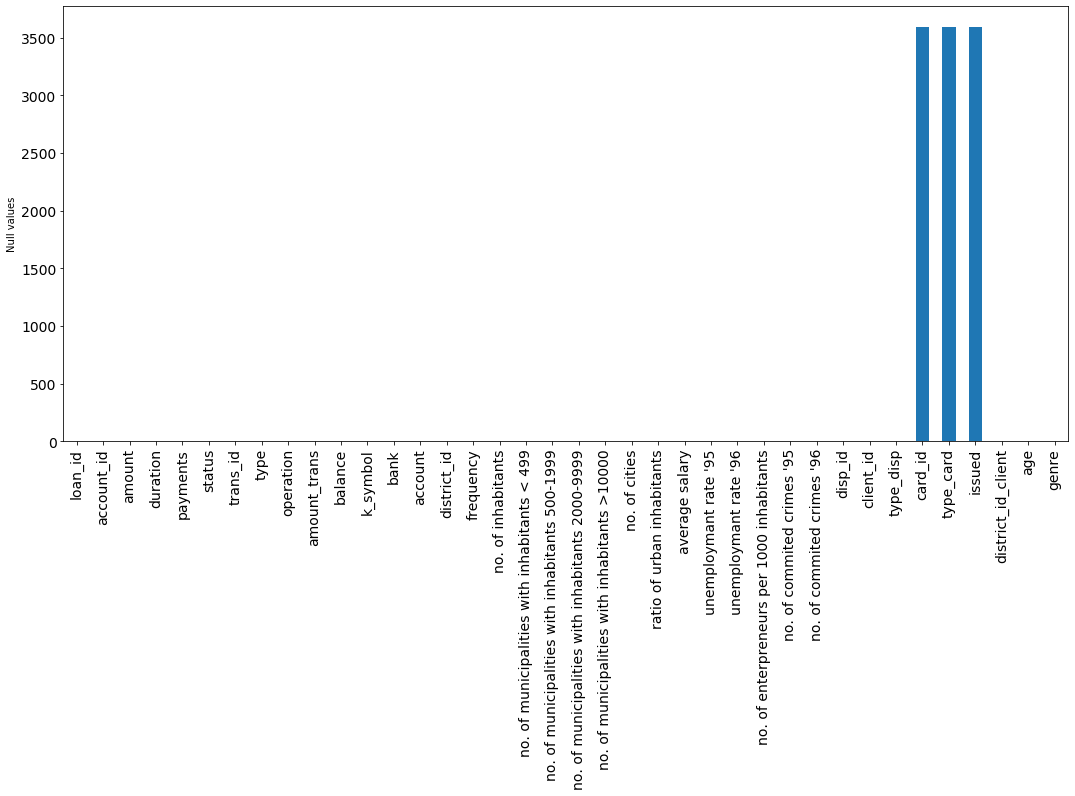

In [12]:
train_data.isnull().sum().plot(kind='bar', figsize=(18,8), fontsize=14,);
plt.ylabel('Null values');

In [13]:
print(train_data.frequency.value_counts())
print()
print(train_data.type.value_counts())
print()
print(train_data.type_card.value_counts())
print()
print(train_data.operation.value_counts())
print()
print(train_data.k_symbol.value_counts())
print()
print(train_data.bank.value_counts())

monthly issuance              3213
weekly issuance                493
issuance after transaction      75
Name: frequency, dtype: int64

withdrawal    3781
Name: type, dtype: int64

classic    165
gold        24
Name: type_card, dtype: int64

remittance to another bank    3781
Name: operation, dtype: int64

household             2051
                      1226
insurrance payment     504
Name: k_symbol, dtype: int64

EF    487
YZ    390
AB    346
ST    338
QR    309
KL    300
UV    268
CD    266
IJ    241
OP    232
WX    221
MN    215
GH    168
Name: bank, dtype: int64


In [14]:
train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'type'], axis=1, inplace=True)
test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'type'], axis=1, inplace=True)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 3780
Data columns (total 33 columns):
loan_id                                             3781 non-null float64
account_id                                          3781 non-null float64
amount                                              3781 non-null float64
duration                                            3781 non-null float64
payments                                            3781 non-null float64
status                                              3781 non-null float64
trans_id                                            3781 non-null float64
amount_trans                                        3781 non-null float64
balance                                             3781 non-null float64
district_id                                         3781 non-null float64
frequency                                           3781 non-null object
no. of inhabitants                                  3781 non-null float64
no. of

In [16]:
train_data = pd.get_dummies(train_data, columns=['frequency'], dtype=bool)
test_data = pd.get_dummies(test_data, columns=['frequency'], dtype=bool)

train_data = pd.get_dummies(train_data, columns=['type_card'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_card'], dtype = bool)

train_data = pd.get_dummies(train_data, columns=['type_disp'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_disp'], dtype = bool)

test_data = test_data.drop_duplicates(subset=['loan_id'], keep='first')

#train_data = pd.get_dummies(train_data)
#test_data = pd.get_dummies(test_data)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 3780
Data columns (total 37 columns):
loan_id                                             3781 non-null float64
account_id                                          3781 non-null float64
amount                                              3781 non-null float64
duration                                            3781 non-null float64
payments                                            3781 non-null float64
status                                              3781 non-null float64
trans_id                                            3781 non-null float64
amount_trans                                        3781 non-null float64
balance                                             3781 non-null float64
district_id                                         3781 non-null float64
no. of inhabitants                                  3781 non-null float64
no. of municipalities with inhabitants < 499        3781 non-null float64
no. o

In [17]:
competition_inputs = test_data.drop(columns=["loan_id", "status"])
test_data = test_data.drop(columns=["status"])
all_ids_comp = test_data['loan_id'].values

5 Dropped columns: ["unemploymant rate '96", "no. of commited crimes '95", "no. of commited crimes '96", 'client_id', 'type_disp_OWNER']


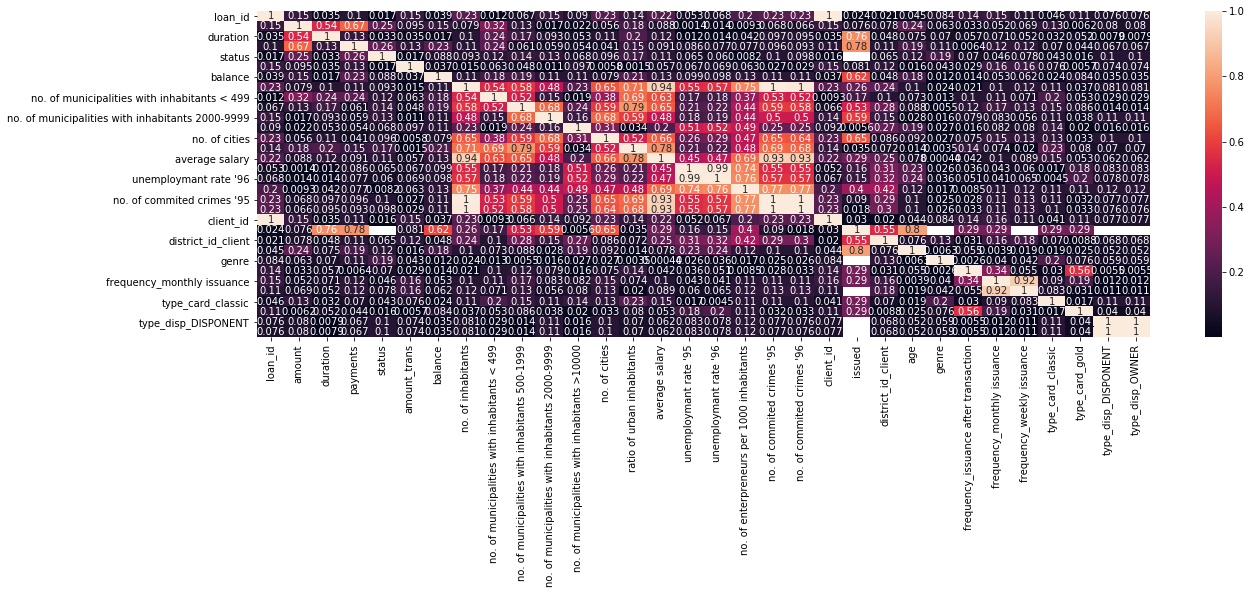

In [18]:
# Dropping ids
#train_data_no_ids = train_data.drop(['loan_id', 'account_id', 'district_id', 'disp_id', 'client_id', 'card_id', 'trans_id'], axis=1)
train_data_no_ids = train_data.drop(['account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)


# Create correlation matrix
corr_matrix = train_data_no_ids.corr().abs()
plt.figure(figsize = (20,6))
sb.heatmap(corr_matrix, annot=True)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_data_no_ids.drop(to_drop, axis=1, inplace=True)

print("{} Dropped columns: {}".format(len(to_drop), to_drop) )

In [19]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,issued,district_id_client,age,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_disp_DISPONENT
0,5316.0,165960.0,36.0,4610.0,1.0,956.0,70740.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
1,5316.0,165960.0,36.0,4610.0,1.0,3419.0,103028.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
2,5316.0,165960.0,36.0,4610.0,1.0,4167.0,98861.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
3,5316.0,165960.0,36.0,4610.0,1.0,956.0,31481.0,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
4,5316.0,165960.0,36.0,4610.0,1.0,3419.0,28062.0,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False


In [20]:
# Removing rows with nan values for status
#train_data_no_ids.dropna(subset=["status"], inplace=True)

#print(no_ids.drop_duplicates(inplace=True)
print(train_data_no_ids["status"].value_counts())

 1.0    3634
-1.0     147
Name: status, dtype: int64


In [21]:
train_data_no_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 3780
Data columns (total 27 columns):
loan_id                                             3781 non-null float64
amount                                              3781 non-null float64
duration                                            3781 non-null float64
payments                                            3781 non-null float64
status                                              3781 non-null float64
amount_trans                                        3781 non-null float64
balance                                             3781 non-null float64
no. of inhabitants                                  3781 non-null float64
no. of municipalities with inhabitants < 499        3781 non-null float64
no. of municipalities with inhabitants 500-1999     3781 non-null float64
no. of municipalities with inhabitants 2000-9999    3781 non-null float64
no. of municipalities with inhabitants >10000       3781 non-null float64
no. o

In [22]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,issued,district_id_client,age,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_disp_DISPONENT
0,5316.0,165960.0,36.0,4610.0,1.0,956.0,70740.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
1,5316.0,165960.0,36.0,4610.0,1.0,3419.0,103028.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
2,5316.0,165960.0,36.0,4610.0,1.0,4167.0,98861.2,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
3,5316.0,165960.0,36.0,4610.0,1.0,956.0,31481.0,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False
4,5316.0,165960.0,36.0,4610.0,1.0,3419.0,28062.0,112709.0,48.0,20.0,...,NaN,46,53,1,False,True,False,False,False,False


In [23]:
# Removing labels and creating another dataset for them
train_data_no_ids = train_data_no_ids.dropna()
all_inputs = train_data_no_ids[train_data_no_ids.columns.drop(['loan_id'])]
all_labels = train_data_no_ids['status'].values

competition_inputs = test_data.drop(columns=["loan_id"])
all_ids_comp = test_data['loan_id'].values

#all_inputs = train_data_no_ids.iloc[:, :-1].values
#all_labels = train_data_no_ids.iloc[:, -1].values

In [24]:
# get a test dataset with 25% of the credit_data_subset
(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)
#(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, random_state=1)

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 2980 to 1955
Data columns (total 26 columns):
amount                                              141 non-null float64
duration                                            141 non-null float64
payments                                            141 non-null float64
status                                              141 non-null float64
amount_trans                                        141 non-null float64
balance                                             141 non-null float64
no. of inhabitants                                  141 non-null float64
no. of municipalities with inhabitants < 499        141 non-null float64
no. of municipalities with inhabitants 500-1999     141 non-null float64
no. of municipalities with inhabitants 2000-9999    141 non-null float64
no. of municipalities with inhabitants >10000       141 non-null float64
no. of cities                                       141 non-null float64
ratio of urban 

Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48




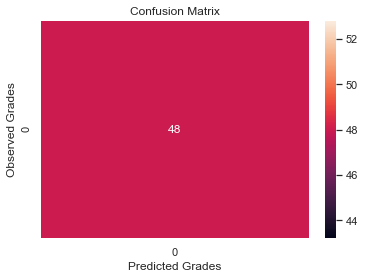

In [26]:
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(all_inputs, all_labels)

dtc_prediction = decision_tree_classifier.predict(X_test)

dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()